### Import

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime as dt
from datetime import date
import calendar
from calendar import weekday, day_name
import re
import statsmodels.api as sm
from tqdm import tqdm

import requests
from bs4 import BeautifulSoup
from datetime import datetime

from scipy import stats
from sklearn import preprocessing
import re

### 테이블 현황 파악을 위한 함수

In [7]:
# 테이블 현황 파악을 위한 함수 
def summary_table(table):
    df = pd.DataFrame()
    for i in table.columns:
        name = i
        dtype = table[i].dtype.name
        null = table[i].isnull().sum()
        act = table.shape[0] - null
        unique = len(table[i].unique())
        data = {'name': name, 'dtype': dtype, 'null': null, 'act': act, 'unique': unique}
        df = df.append(data, ignore_index=True)
    return df

## 1. PreProcessing

### 1-1. read_csv

In [9]:
key = pd.read_csv('data/key.csv')
summary_table(key)

,act,dtype,name,null,unique
0,45.0,int64,store_nbr,0.0,45.0
1,45.0,int64,station_nbr,0.0,20.0


In [10]:
weather = pd.read_csv("data/weather.csv", parse_dates=['date']) # station 20개 별 날씨 정보
summary_table(weather).pivot_table(index=['dtype', 'name'])

act  null  unique
dtype          name                              
datetime64[ns] date         20517.0   0.0  1035.0
int64          station_nbr  20517.0   0.0    20.0
object         avgspeed     20517.0   0.0   254.0
               codesum      20517.0   0.0   449.0
               cool         20517.0   0.0    37.0
               depart       20517.0   0.0    66.0
               dewpoint     20517.0   0.0    99.0
               heat         20517.0   0.0    77.0
               preciptotal  20517.0   0.0   285.0
               resultdir    20517.0   0.0    37.0
               resultspeed  20517.0   0.0   249.0
               sealevel     20517.0   0.0   153.0
               snowfall     20517.0   0.0    77.0
               stnpressure  20517.0   0.0   322.0
               sunrise      20517.0   0.0   219.0
               sunset       20517.0   0.0   223.0
               tavg         20517.0   0.0   112.0
               tmax         20517.0   0.0   121.0
               tmin         20517.0   0.0   108.0
               wetbulb      20517.0   0.0    93.0

In [11]:
weather[:2] # null 값 및 missing value의 이슈가 있음

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,1,2012-01-01,52,31,42,M,36,40,23,0,-,-,RA FZFG BR,M,0.05,29.78,29.92,3.6,20,4.6
1,2,2012-01-01,48,33,41,16,37,39,24,0,0716,1626,RA,0.0,0.07,28.82,29.91,9.1,23,11.3


In [12]:
train = pd.read_csv('data/train.csv', parse_dates=['date'])
summary_table(train)

,act,dtype,name,null,unique
0,4617600.0,datetime64[ns],date,0.0,1034.0
1,4617600.0,int64,store_nbr,0.0,45.0
2,4617600.0,int64,item_nbr,0.0,111.0
3,4617600.0,int64,units,0.0,394.0


### 1-2. Preprocessing_weather

#### 1-2-1. holidays 추가: 날씨의 날짜(date)를 기준으로 holiday를 추가

In [13]:
def get_holidays(year):
    response = requests.get("https://www.timeanddate.com/calendar/custom.html?year="+str(year)+"&country=1&cols=3&df=1&hol=25")
    dom = BeautifulSoup(response.content, "html.parser")

    trs = dom.select("table.cht.lpad tr")

    df = pd.DataFrame(columns=["date", "holiday", "blackfriday"])
    for tr in trs:
        datestr = tr.select_one("td:nth-of-type(1)").text
        date = datetime.strptime("{} {}".format(year, datestr), '%Y %b %d')
        holiday = tr.select_one("td:nth-of-type(2)").text
        df.loc[len(df)] = {"date" : date, "holiday": 1, "blackfriday": 0}
    return df

holiday_ls = []
for year in range(2012, 2015):
    df = get_holidays(year)
    holiday_ls.append(df)
holiday_df = pd.concat(holiday_ls)

holiday_df.loc[len(holiday_df)] = {"date":datetime(2012, 11, 23, 0, 0), "holiday":0, "blackfriday":1}
holiday_df.loc[len(holiday_df)] = {"date":datetime(2012, 11, 24, 0, 0), "holiday":0, "blackfriday":2}
holiday_df.loc[len(holiday_df)] = {"date":datetime(2012, 11, 25, 0, 0), "holiday":0, "blackfriday":3}
holiday_df.loc[len(holiday_df)] = {"date":datetime(2012, 11, 26, 0, 0), "holiday":0, "blackfriday":4}

holiday_df.loc[len(holiday_df)] = {"date":datetime(2013, 11, 29, 0, 0), "holiday":0, "blackfriday":1}
holiday_df.loc[len(holiday_df)] = {"date":datetime(2013, 11, 30, 0, 0), "holiday":0, "blackfriday":2}
holiday_df.loc[len(holiday_df)] = {"date":datetime(2013, 12, 1, 0, 0), "holiday":0, "blackfriday":3}
holiday_df.loc[len(holiday_df)] = {"date":datetime(2013, 12, 2, 0, 0), "holiday":0, "blackfriday":4}

holiday_df.loc[len(holiday_df)] = {"date":datetime(2014, 11, 28, 0, 0), "holiday":0, "blackfriday":1}
holiday_df.loc[len(holiday_df)] = {"date":datetime(2014, 11, 29, 0, 0), "holiday":0, "blackfriday":2}
holiday_df.loc[len(holiday_df)] = {"date":datetime(2014, 11, 30, 0, 0), "holiday":0, "blackfriday":3}
holiday_df.loc[len(holiday_df)] = {"date":datetime(2014, 12, 1, 0, 0), "holiday":0, "blackfriday":4}

holiday_df = holiday_df.sort_values(by="date").reset_index(drop=True)
holiday_df["date"] = pd.to_datetime(holiday_df["date"]) # 날짜형식으로 변환
holiday_df["isbf"] = holiday_df["blackfriday"].apply(lambda x: 0 if x==0 else 1)

#### 1-2-2. weather data의 null값 처리

In [14]:
# weather data 정리
tw = weather.copy() # 원복 복사
for col in tw.columns: # 모든 column data type 확인
    dt = type(tw[col].values[0]) # data frame의 seriese의 values[0] data의 type을 확인
    if dt.__name__ == "str":
        tw.loc[:][col] = tw[col].str.strip() # 공백제거
        if "M" in set(tw[col]): # M 이 들어있는 컬럼 변경하기
            idx = tw[col] == "M"
            tw.loc[idx, col] = -99999
        
        if "T" in set(tw[col]): # T 이 들어있는 컬럼 변경하기, 
            idx = tw[col] == "T"
            tw.loc[idx, col] = 0

for col in tw.columns:
    # 날짜, 일출, 일몰, 요약 부분은 type을 변경하지 않는다.
    if col == "date" or col == "sunrise" or col == "sunset" or col == "codesum":
        continue

    if col == "station_nbr" or col == "item_nbr" or col == "store_nbr" or col == "units":
        tw[col] = tw[col].astype(int)
        continue

    # 숫자로 변환되어야 할 수치 데이터들 type 변경하기 
    tw[col] = tw[col].astype(float) 


# -99999 np.nan으로 변경하기
for col in tw.columns:
    try:
        tw.loc[tw[col] == -99999, col] = np.nan
    except Exception as e:
        print(col,e)
        pass

#depart : 빈칸채우기
departmean = tw["depart"].mean()
tw["depart"] = tw["depart"].fillna(departmean)
 
tw = tw.fillna(method='ffill')
tw = tw.fillna(method='bfill')

weather = tw.copy()
del tw

date invalid type comparison


In [15]:
# weather["date365"] = weather["date"].apply(lambda x : x[5:])

# date = pd.to_datetime(weather["date"])
weather["week"] = weather.date.dt.week # 몇번째 주인지 컬럼추가
weather["weekday"] = weather.date.dt.weekday
weather["month"] = weather.date.dt.month
weather["day"] = weather.date.dt.day
weather["year"] = weather.date.dt.year
weather["quater"] = weather.date.dt.quarter
weather["half"] = weather["month"].apply(lambda x : 1 if x>3 and x<10 else 0)
weather["weekend"] = weather["weekday"].apply(lambda x : 1 if x>=5 else 0)


# 휴일 추가
weather = pd.merge(left=weather, right=holiday_df, how="left", on="date")
weather["holiday"] = weather["holiday"].fillna(0) 
weather["holiday"] = weather["holiday"].astype(int)
weather["blackfriday"] = weather["blackfriday"].fillna(0)
weather["blackfriday"] = weather["blackfriday"].astype(int)
weather["isbf"] = weather["isbf"].fillna(0)
weather["isbf"] = weather["isbf"].astype(int)
weather["weekindicator"] = weather["weekday"].apply(lambda x: 0 if x<=3 else 1)

In [16]:
#event date 구하기
res = weather.filter(items=["date", "snowfall", "preciptotal", "depart"])
# res["date"] = pd.to_datetime(res["date"])
  
ed = res[(res["preciptotal"]> 1) | (res["snowfall"]>2)]
dayls=[]
for date in ed["date"]: 
    b3 = date - pd.Timedelta(days=3) # 3일전 날짜 구하기
    dr = pd.date_range(b3, periods=7) # 3일전 부터 7일 기간 구하기
    dayls.extend(dr.tolist()) # 날짜 범위 리스트에 저장 
dayls = list(set(dayls))
weather["event"] = res["date"].apply(lambda x : 1 if x in dayls else 0)

#### 1-2-3. 더미 변수 및 컬럼을 만들기 위한 함수(활용여부 검토중)

In [17]:
def make_token(ls):
    token_ls = ''
    for i in ls:
        token_ls = token_ls + i
    return token_ls

def validation(token, ls):
    result = []
    for each in ls:
        if each in token:
            token = token.replace(each,'')
            result.append(each)
    return result

def make_dummies(table, ls, table_ls):
    dummies = pd.DataFrame(np.zeros((len(table), len(ls))), columns = ls)
    
    for i, gen in enumerate(table_ls):
        dummies.ix[i, validation(gen, ls)] = '1'
        
    table = table.join(dummies)
    return table

##### Codesum 처리

In [18]:
# ls_codesum = ['+FC', 'FC', 'TS', 'GR', 'RA', 'DZ', 'SN', 'SG', 'GS', 'PL', 'IC', 'FG+',
#       'FG', 'BR', 'UP', 'HZ', 'FU', 'VA', 'DU', 'DS', 'PO', 'SO', 'SA', 'SS',
#       'PY', 'SQ', 'DR', 'SH', 'FZ', 'MI', 'PR', 'BC', 'BL', 'VC']
# weather_cs = make_dummies(weather_cs, ls_codesum, weather.codesum)

##### weekday 처리

In [19]:
# ls_weekday = list(weather_cs.weekday.unique())
# weather_cs = make_dummies(weather_cs, ls_weekday, weather_cs.weekday)

##### month 처리

In [20]:
# ls_month = list(weather_cs.month.unique())
# weather_cs = make_dummies(weather_cs, ls_month, weather_cs.month)

##### holiday_name 처리

In [21]:
# ls_holiday_name = list(weather_cs.holiday_name.unique())
# weather_cs = make_dummies(weather_cs, ls_holiday_name, weather_cs.holiday_name)


#### 1-2-4. data 분포

In [22]:
cols = ['tmax', 'tmin', 'tavg', 'depart', 'dewpoint',
       'wetbulb', 'heat', 'cool', 'snowfall',
       'preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 'resultdir',
       'avgspeed']
plt.figure(figsize=(20, 5))
for idx, col in enumerate(cols):
    plt.subplot(2, 8, idx + 1)
    sns.distplot(weather[col])
plt.tight_layout(pad=2, h_pad=1)
plt.show()

#### 의견
- 일부 분포가 고르지 못한 feature에 대해서 정규화를 해줄 필요가 있음

### 1-3 Merge 및 train set 생성

#### 1-3-1. station_nbr을 기준으로 key값을 형성하여 train set(data)를 생성

In [23]:
def fs(store_nbr):
    res = key[key["store_nbr"]==store_nbr] # key 테이블에서 관측소 ID 검색 
    res = res.sort_values(by="store_nbr").reset_index(drop=True)
    return res["station_nbr"][0]

tables = []
for idx in list(set(train["store_nbr"])):
    station_nbr = fs(idx)
    t = train[train["store_nbr"] == idx].copy()
    t["station_nbr"] = station_nbr
    tables.append(t)
add_station_nbr = pd.concat(tables)
data = pd.merge(left=weather, right=add_station_nbr, how="inner", on=["station_nbr", "date"])

In [24]:
data.shape

(4626480, 36)

#### 1-3-2. 판매량이 없는 units을 filtering

In [25]:
#판매량 없는 유닛 걸러냄
train_filtered = data.groupby(["store_nbr", "item_nbr"])['units'].mean()
train_filtered = train_filtered[train_filtered > 0.0]

store_nbrs = train_filtered.index.get_level_values(0)
item_nbrs = train_filtered.index.get_level_values(1)

res = sorted(zip(store_nbrs, item_nbrs), key = lambda t: t[1] * 10000 + t[0] )
res = pd.DataFrame(res, columns=["store_nbr", "item_nbr"])

#merge
store_item_nbr = pd.merge(left=res, right=key, how="left", on="store_nbr")
store_item_nbr = store_item_nbr.sort_values(by=["station_nbr","store_nbr","item_nbr"]).reset_index(drop=True)
store_item_nbr[:3]

,store_nbr,item_nbr,station_nbr
0,1,9,1
1,1,28,1
2,1,40,1


In [26]:
# 점포별 판매된 아이템 정보만 추출
def get_data_by_store(nbr):
    idx = store_item_nbr[store_item_nbr["store_nbr"] == nbr]["item_nbr"]
    res = data[data["store_nbr"] == nbr]
    res = res[res["item_nbr"].isin(idx)].reset_index(drop=True)
    return res

In [27]:
store_check = []
for i in range(45):
    s_nbr = i+1
    df = get_data_by_store(s_nbr)
    item_nbrs = set(df["item_nbr"])
    store_check.append([s_nbr, len(df), item_nbrs])
pd.DataFrame(store_check, columns=["store_nbr", "data length", "item_nbrs"])

,store_nbr,data length,item_nbrs
0,1,7440,"{99, 40, 9, 47, 51, 89, 28, 93}"
1,2,4385,"{5, 11, 44, 85, 93}"
2,3,5388,"{2, 5, 102, 45, 109, 93}"
3,4,6734,"{96, 97, 101, 9, 90, 27, 93}"
4,5,5340,"{32, 37, 105, 16, 20, 93}"
5,6,3508,"{9, 107, 45, 14}"
6,7,4640,"{5, 7, 23, 93, 95}"
7,8,5532,"{100, 5, 84, 23, 59, 93}"
8,9,5694,"{5, 105, 10, 42, 45, 93}"
9,10,4450,"{37, 5, 21, 86, 93}"


In [28]:
def concat_all_sotre_dataframe():
    all_s_df = []
    for i in range(1,46):
        s_df = get_data_by_store(i)
        all_s_df.append(s_df)
    return pd.concat(all_s_df).reset_index(drop=True)

In [29]:
data_without_zero = concat_all_sotre_dataframe()
data_without_zero.tail()

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,half,weekend,holiday,blackfriday,isbf,weekindicator,event,store_nbr,item_nbr,units
236477,16,2014-10-31,53.0,34.0,44.0,1.363091,35.0,41.0,21.0,0.0,...,0,0,1,0,0,1,0,45,9,10
236478,16,2014-10-31,53.0,34.0,44.0,1.363091,35.0,41.0,21.0,0.0,...,0,0,1,0,0,1,0,45,22,0
236479,16,2014-10-31,53.0,34.0,44.0,1.363091,35.0,41.0,21.0,0.0,...,0,0,1,0,0,1,0,45,26,1
236480,16,2014-10-31,53.0,34.0,44.0,1.363091,35.0,41.0,21.0,0.0,...,0,0,1,0,0,1,0,45,34,0
236481,16,2014-10-31,53.0,34.0,44.0,1.363091,35.0,41.0,21.0,0.0,...,0,0,1,0,0,1,0,45,50,0


#### 아웃라이어 제거

In [30]:
#이상치 제거
data_without_zero = data_without_zero[data_without_zero["units"] < 3000]
# data_without_zero["logunits"] = np.log1p(data_without_zero["units"])
data_without_zero.tail()

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,half,weekend,holiday,blackfriday,isbf,weekindicator,event,store_nbr,item_nbr,units
236477,16,2014-10-31,53.0,34.0,44.0,1.363091,35.0,41.0,21.0,0.0,...,0,0,1,0,0,1,0,45,9,10
236478,16,2014-10-31,53.0,34.0,44.0,1.363091,35.0,41.0,21.0,0.0,...,0,0,1,0,0,1,0,45,22,0
236479,16,2014-10-31,53.0,34.0,44.0,1.363091,35.0,41.0,21.0,0.0,...,0,0,1,0,0,1,0,45,26,1
236480,16,2014-10-31,53.0,34.0,44.0,1.363091,35.0,41.0,21.0,0.0,...,0,0,1,0,0,1,0,45,34,0
236481,16,2014-10-31,53.0,34.0,44.0,1.363091,35.0,41.0,21.0,0.0,...,0,0,1,0,0,1,0,45,50,0


## 2. EDA & Feature selection

In [33]:
df = data_without_zero.copy()

In [42]:
%matplotlib inline

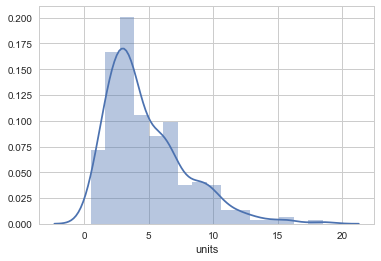

In [73]:
sns.distplot(sp1['units'])

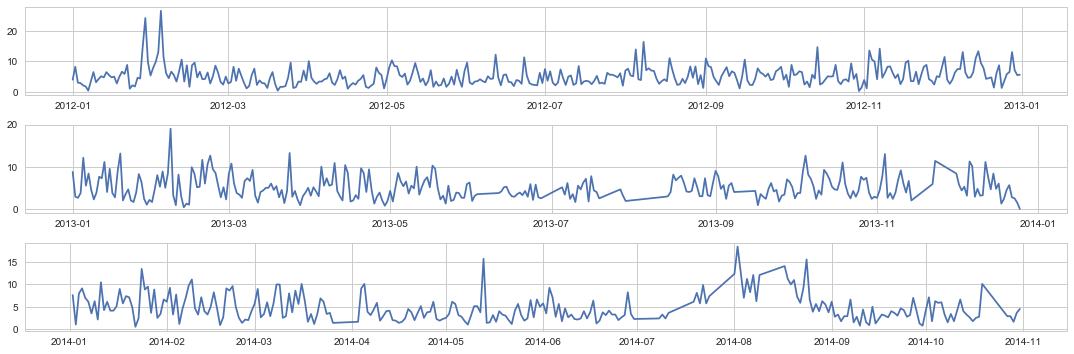

In [72]:
plt.figure(figsize=(15, 5))
for idx, year in enumerate(range(2012, 2015)):
    
    s1 = df[df['store_nbr']==1]
    s1 = s1[s1['year']==year]
    sp1 = s1.pivot_table(index='date', values='units')
    plt.subplot(3, 1, idx+1)
    plt.plot(sp1['units'])
plt.tight_layout(pad=1, h_pad=1)
plt.show()

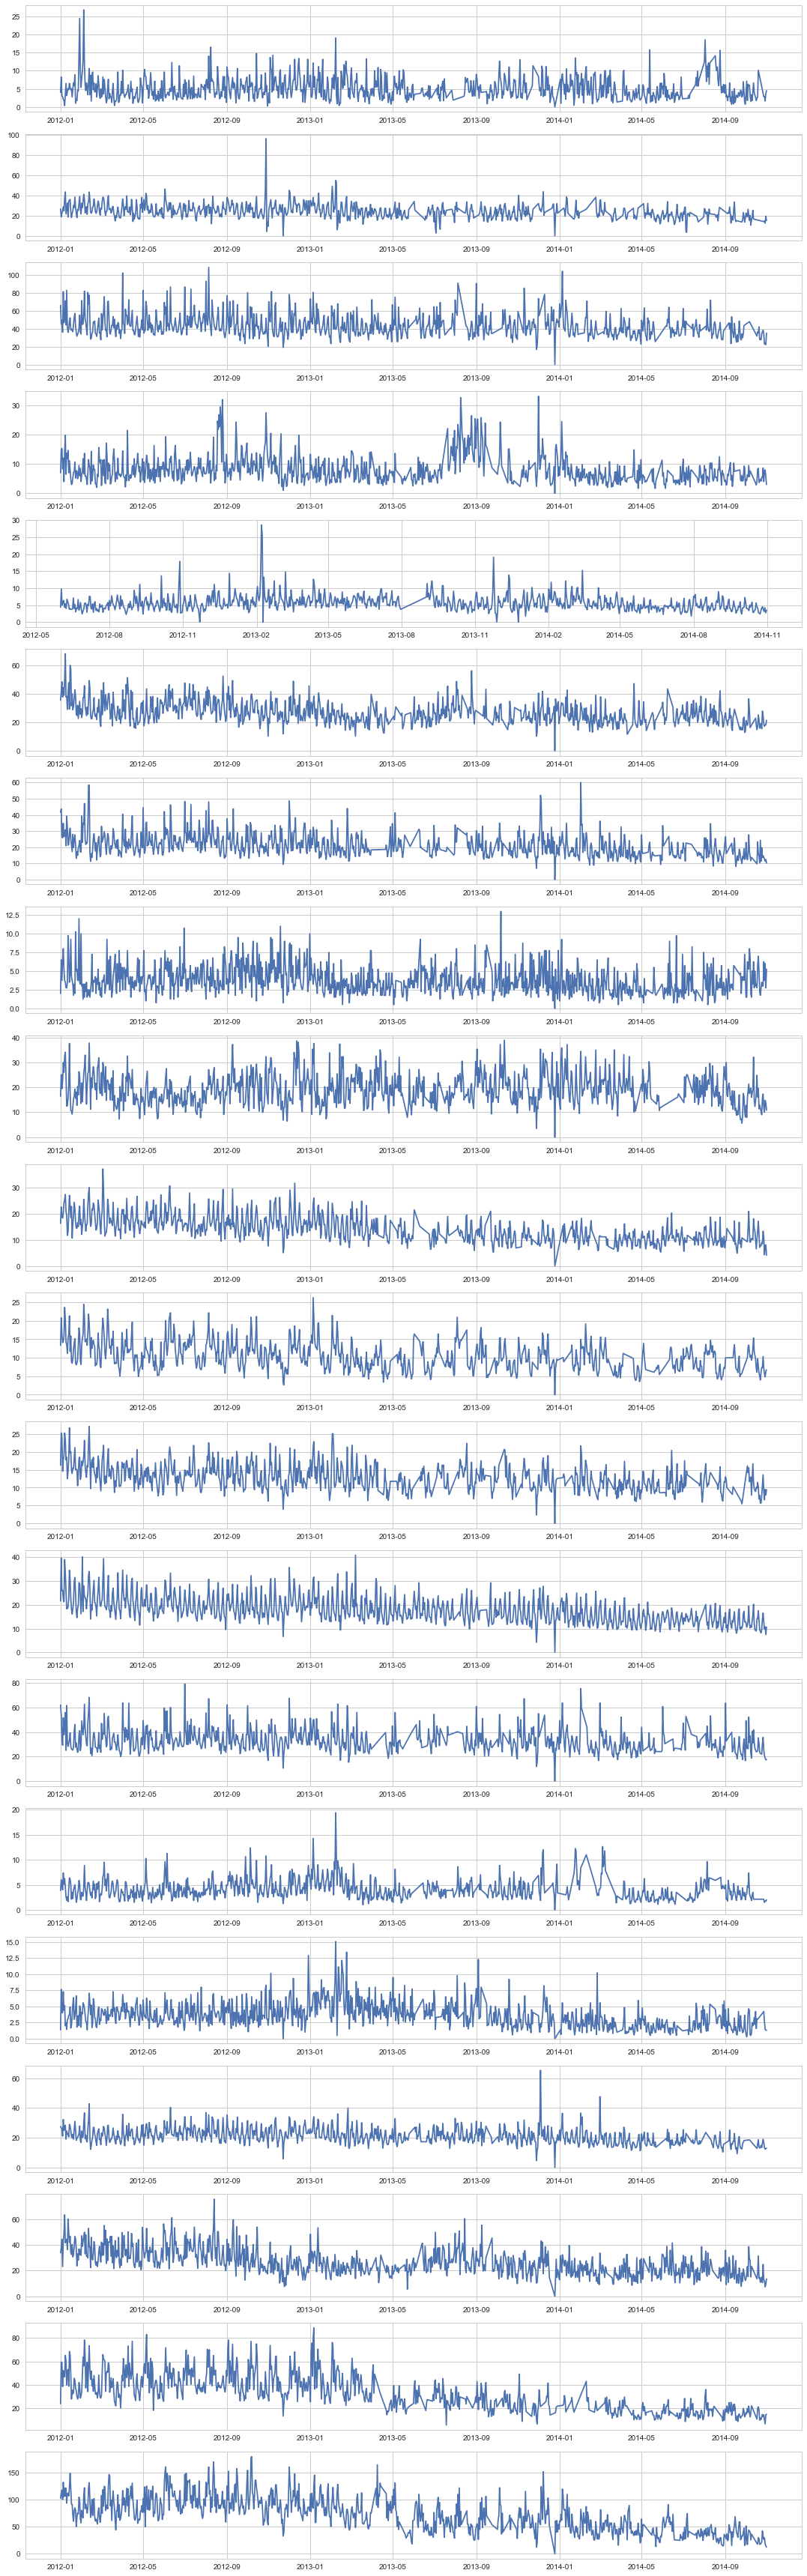

In [55]:
plt.figure(figsize=(15, 50))
for snum in range(1, 21):
    plt.subplot(21, 1, snum)
    
    s1 = df[df['station_nbr']==snum]
    sp1 = s1.pivot_table(index='date', values='units')
    plt.plot(sp1['units'])
plt.tight_layout(pad=1, h_pad=1)
plt.show()

In [33]:
summary_table(df).pivot_table(index = ['dtype', 'name'])

act  null   unique
dtype          name                                  
datetime64[ns] date           236480.0   0.0   1034.0
float64        avgspeed       236480.0   0.0  17949.0
               cool           236480.0   0.0     36.0
               depart         236480.0   0.0     64.0
               dewpoint       236480.0   0.0  17895.0
               heat           236480.0   0.0     76.0
               preciptotal    236480.0   0.0    230.0
               resultdir      236480.0   0.0     36.0
               resultspeed    236480.0   0.0  17948.0
               sealevel       236480.0   0.0    151.0
               snowfall       236480.0   0.0     62.0
               stnpressure    236480.0   0.0  17949.0
               tavg           236480.0   0.0  17946.0
               tmax           236480.0   0.0  17950.0
               tmin           236480.0   0.0  17935.0
               wetbulb        236480.0   0.0  17938.0
int64          blackfriday    236480.0   0.0      5.0
               day            236480.0   0.0     31.0
               event          236480.0   0.0      2.0
               half           236480.0   0.0      2.0
               holiday        236480.0   0.0      2.0
               isbf           236480.0   0.0      2.0
               item_nbr       236480.0   0.0    111.0
               month          236480.0   0.0     12.0
               quater         236480.0   0.0      4.0
               store_nbr      236480.0   0.0     45.0
               units          236480.0   0.0    392.0
               week           236480.0   0.0     52.0
               weekday        236480.0   0.0      7.0
               weekend        236480.0   0.0      2.0
               weekindicator  236480.0   0.0      2.0
               year           236480.0   0.0      3.0
object         codesum        236480.0   0.0    409.0
               station_nbr    236480.0   0.0     20.0
               sunrise        236480.0   0.0    219.0
               sunset         236480.0   0.0    223.0

In [34]:
#더미 변수화 하였으므로 해당 컬럼 삭제 & dummy 처리한 feature 중 unique가 1개(즉, 값이 없다는 의미)인 feature 삭제
# ls_drop = ['weekday', 'codesum', 'month', 'holiday_name',
#            '+FC', 'BlackFriday1', 'BlackFriday2', 'BlackFriday3', 'DR', 'DS', 'FC', 'IC', 'PO',
#            'PY', 'SA', 'SH', 'SO', 'SS' , 'VA']
# ls_drop = ['codesum', '+FC','DR', 'DS', 'FC', 'IC', 'PO',
#            'PY', 'SA', 'SH', 'SO', 'SS' , 'VA', 'FG+']
# df = df.drop(ls_drop, axis=1)

### 2-1. data type 별 현황 요약

In [35]:
summary_df = pd.DataFrame()

for i in df.columns:
    column_names = i
    column_dtype = df[i].dtype.name
    column_rows = len(df[i])
    
    data = {'Name':column_names, 'dtype': column_dtype, 'rows': column_rows}
    summary_df = summary_df.append(data, ignore_index=True)

summary_df['Count'] = 1
summary_df.pivot_table(values='Count', index='dtype', aggfunc=np.sum)

,Count
dtype,
datetime64[ns],1
float64,15
int64,16
object,4


In [36]:
# # catgory로 분류 되어야 할 4개의 변수의 데이터 타입 변홥 및 공백인 feature 제거
df.event = df.event.astype(object)
df.half = df.half.astype(object)
df.holiday = df.holiday.astype(object)
df.isbf = df.isbf.astype(object)
df.month = df.month.astype(object)
df.quater = df.quater.astype(object)
df.week = df.week.astype(object)
df.weekday = df.weekday.astype(object)
df.weekindicator = df.weekindicator.astype(object)
df.year = df.year.astype(object)
df.weekend = df.weekend.astype(object)

In [37]:
ls_cat = []
ls_numeric = []

for i in df.columns:
    if df[i].dtype == 'float64' or df[i].dtype == 'int64':
        ls_numeric.append(i)
    elif df[i].dtype == 'object':
        ls_cat.append(i)

#### station-nbr / store_nbr / item_nbr 은 대상에서 제외

In [39]:
ls_cat = set(ls_cat) - set(['FG+', '', 'station_nbr'])
ls_numeric = set(ls_numeric) - set(['store_nbr', 'station_nbr', 'item_nbr'])
print(ls_cat, ls_numeric)

{'half', 'weekday', 'quater', 'isbf', 'week', 'holiday', 'codesum', 'month', 'event', 'sunrise', 'sunset', 'weekindicator', 'year'} {'units', 'day', 'resultdir', 'depart', 'snowfall', 'preciptotal', 'cool', 'resultspeed', 'sealevel', 'stnpressure', 'tavg', 'avgspeed', 'tmax', 'heat', 'dewpoint', 'blackfriday', 'tmin', 'wetbulb', 'weekend'}


### 2-2. Category Feature

#### 2-2-1. Anova 분석을 통해 중요도가 높은 Feature 선택

In [40]:
table_anova = pd.DataFrame()
for i in ls_cat:
    formula_list = "np.log1p(units) ~" + i
    model_cat = sm.OLS.from_formula(formula_list, data=df)
    table = sm.stats.anova_lm(model_cat.fit(), typ=2)
    table = table.drop('Residual', axis=0)
    table_anova = table_anova.append(table)

table_anova.sort_values(ascending=True, by = 'PR(>F)')

,sum_sq,df,F,PR(>F)
sunrise,6757.004020,218.0,10.119496,1.976263e-323
sunset,5538.779916,222.0,8.131758,1.273502e-244
year,1545.555181,2.0,250.724153,1.687211e-109
weekday,1104.958702,6.0,59.712692,2.945022e-74
weekindicator,686.252279,1.0,222.390164,2.870365e-50
codesum,3015.688002,408.0,2.398825,1.090493e-48
week,864.949029,51.0,5.496252,2.194458e-33
month,466.590827,11.0,13.741249,8.847961e-27
quater,192.833025,3.0,20.815876,1.769687e-13
half,72.794958,1.0,23.570464,1.204985e-06


In [41]:
ls_cat_select = list(table_anova[table_anova['PR(>F)'] < 0.05].index)
ls_cat_select

['half',
 'weekday',
 'quater',
 'week',
 'holiday',
 'codesum',
 'month',
 'sunrise',
 'sunset',
 'weekindicator',
 'year']

### 2-3. Numeric Feature

#### 2-3-1. 양이 너무 많으므로 나누어서 분석

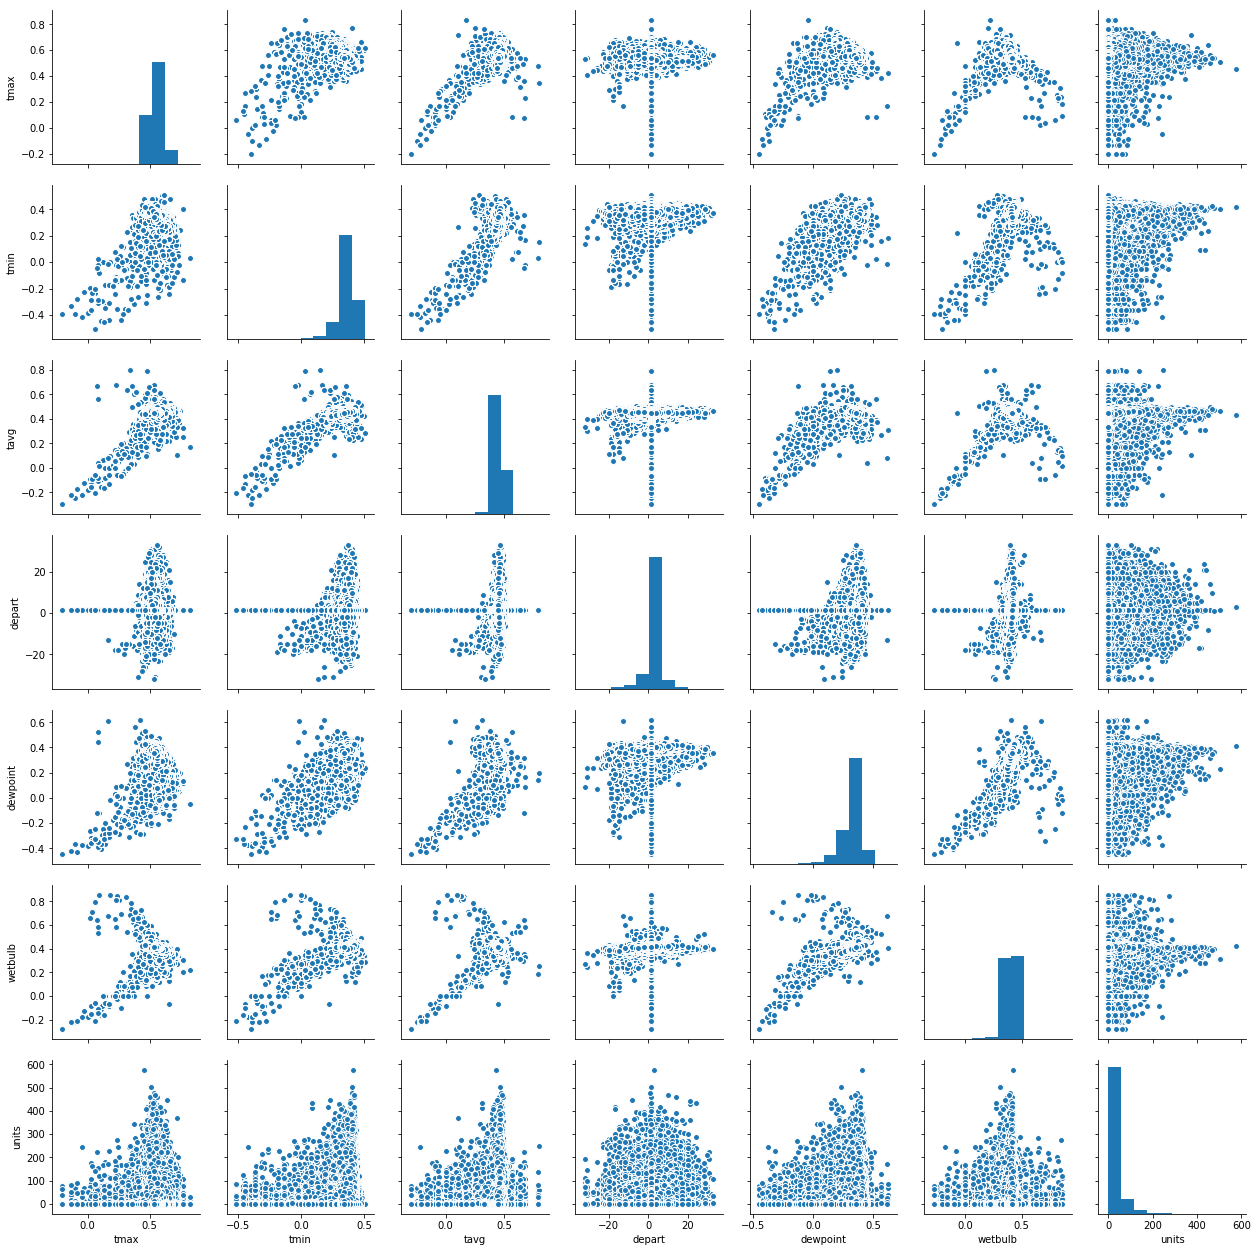

In [42]:
cols = ['tmax', 'tmin', 'tavg', 'depart', 'dewpoint', 'wetbulb', 'units']
sns.pairplot(df[cols])
plt.show()

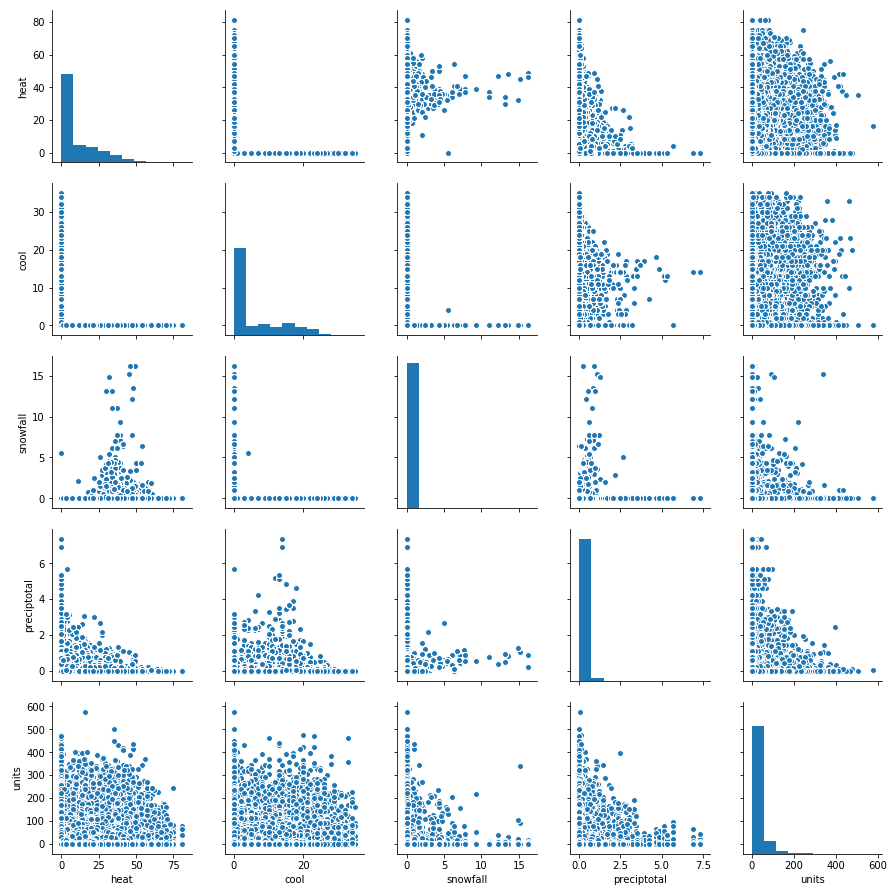

In [43]:
cols = ['heat', 'cool', 'sunrise', 'sunset', 'snowfall', 'preciptotal', 'units']
sns.pairplot(df[cols])
plt.show()

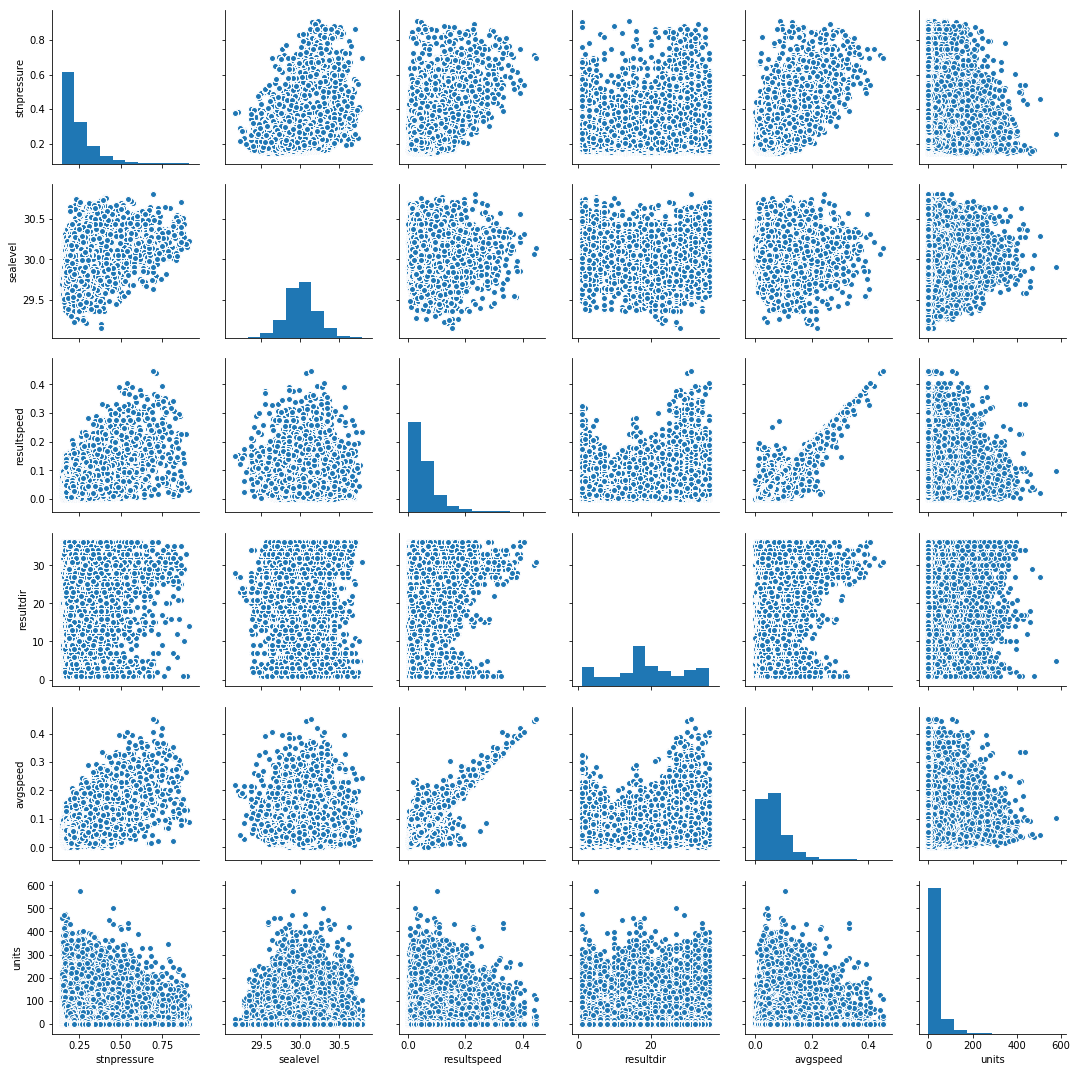

In [44]:
cols = ['stnpressure', 'sealevel', 'resultspeed', 'resultdir', 'avgspeed', 'units']
sns.pairplot(df[cols])
plt.show()

### 의견
- 

### 2-3-2. heatmap을 통한 분석

In [49]:
corr_df = df.filter(ls_numeric)

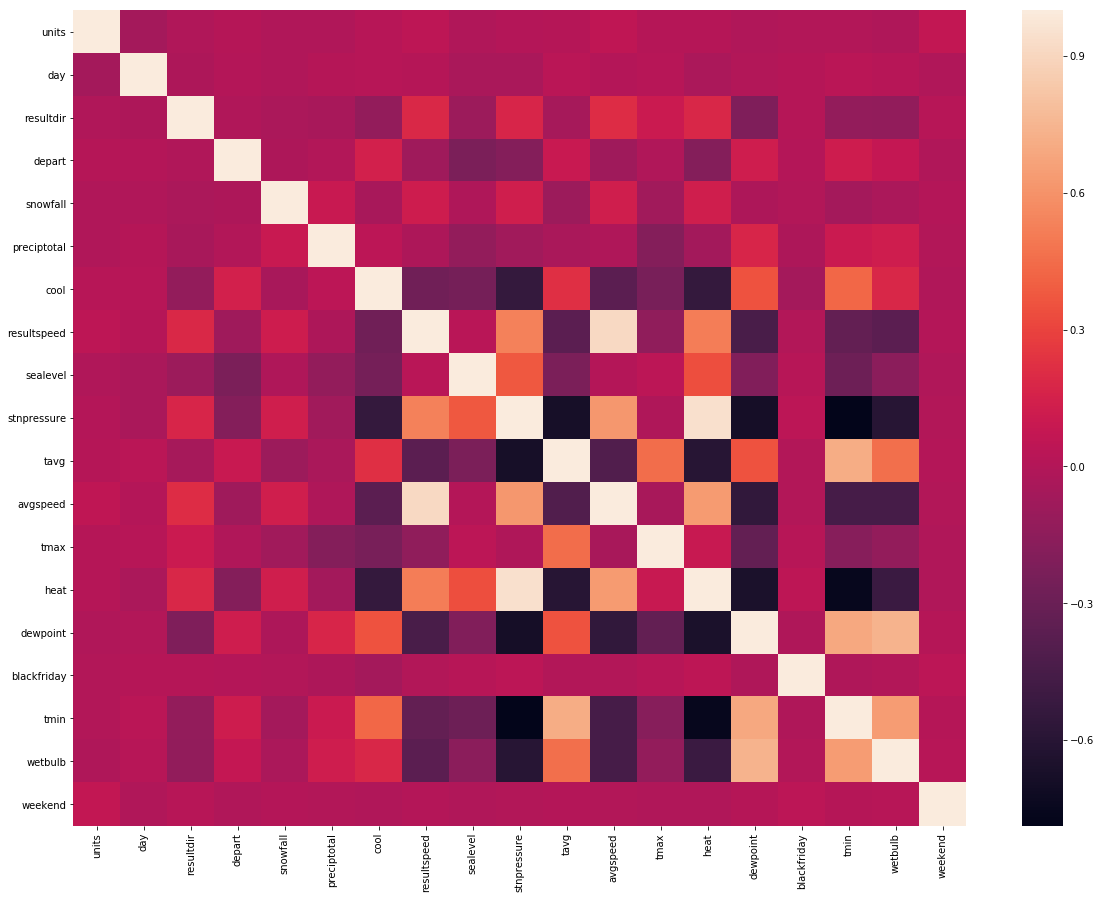

In [50]:
corr = corr_df.corr()
plt.subplots(figsize=(20,15))
sns.heatmap(corr_df.corr())
plt.show()

In [51]:
cor = corr.nlargest(5, 'units')['units'].index
ls_numeric_select = list(cor)
ls_numeric_select

['units', 'weekend', 'avgspeed', 'resultspeed', 'cool']

In [59]:
df

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,half,weekend,holiday,blackfriday,isbf,weekindicator,event,store_nbr,item_nbr,units
0,1,2012-01-01,0.540788,0.322393,0.436790,1.363091,0.374392,0.415991,23.0,0.0,...,0,1,1,0,0,1,0,1,9,29
1,1,2012-01-01,0.540788,0.322393,0.436790,1.363091,0.374392,0.415991,23.0,0.0,...,0,1,1,0,0,1,0,1,28,2
2,1,2012-01-01,0.540788,0.322393,0.436790,1.363091,0.374392,0.415991,23.0,0.0,...,0,1,1,0,0,1,0,1,40,0
3,1,2012-01-01,0.540788,0.322393,0.436790,1.363091,0.374392,0.415991,23.0,0.0,...,0,1,1,0,0,1,0,1,47,0
4,1,2012-01-01,0.540788,0.322393,0.436790,1.363091,0.374392,0.415991,23.0,0.0,...,0,1,1,0,0,1,0,1,51,1
5,1,2012-01-01,0.540788,0.322393,0.436790,1.363091,0.374392,0.415991,23.0,0.0,...,0,1,1,0,0,1,0,1,89,0
6,1,2012-01-01,0.540788,0.322393,0.436790,1.363091,0.374392,0.415991,23.0,0.0,...,0,1,1,0,0,1,0,1,93,0
7,1,2012-01-01,0.540788,0.322393,0.436790,1.363091,0.374392,0.415991,23.0,0.0,...,0,1,1,0,0,1,0,1,99,0
8,1,2012-01-02,0.555150,0.344193,0.455223,1.363091,0.288678,0.388605,24.0,0.0,...,0,0,1,0,0,0,0,1,9,60
9,1,2012-01-02,0.555150,0.344193,0.455223,1.363091,0.288678,0.388605,24.0,0.0,...,0,0,1,0,0,0,0,1,28,5


## 3. Modeling

###  3-1. test set 생성

In [52]:
test = pd.read_csv('tae/test.csv', sep =',', parse_dates= ['date'])
test_key = pd.merge(test, key, on=['store_nbr'], how='left')
test_merge =  pd.merge(test_key, weather, on=['date', 'station_nbr'], how='left')

submission = pd.read_csv('tae/sampleSubmission.csv', sep =',')
submission.drop(labels = ['units'], axis=1, inplace=True)

### 3-2. OLS 모델 적용

In [53]:
# OLS를 개선을 위하여 2차 formulalist를 만드는 함수

def make_formulalist(result):
    formulalist = ''
    for i in filter_pvalue(result):
        if i == 'units' or i == 'logunits':
            continue
        elif re.findall('C', i):
            formulalist += i.replace('T.1', '')[:-2] + '+'
        elif re.findall('scale', i):
            formulalist += i + '+'
                
    formulalist = 'np.log1p(units) ~' + formulalist[:-1]
    
    return formulalist

# pvalue가 10% 미만인 feature만을 골라내어 다시 모델에 적용하는 함수
def filter_pvalue(result):
    p = result.pvalues
    pvalues_dict = dict(p)
    ls_pvalues = []
    for key, value  in pvalues_dict.items():
        if key == 'Intercept': continue
        elif value < 0.1:
            ls_pvalues.append(key)
        else: continue
    ls_pvalues
    return ls_pvalues

In [54]:
ls_numeric_select = set(ls_numeric_select) - set(['sunset', 'cool', 'snowfall'])
ls_numeric_select_modeling = ''
for i in ls_numeric_select:
    if i == 'units' or i == 'logunits':
        continue
    else: ls_numeric_select_modeling += 'scale(' + i + ')' + '+'
        
ls_numeric_select_modeling

'scale(weekend)+scale(avgspeed)+scale(resultspeed)+'

In [55]:
cat_select_modeling = ''
for i in ls_cat_select:
     cat_select_modeling += 'C(' + i + ')'+ '+'
cat_select_modeling

'C(half)+C(weekday)+C(quater)+C(week)+C(holiday)+C(codesum)+C(month)+C(sunrise)+C(sunset)+C(weekindicator)+C(year)+'

In [56]:
model1_df = pd.DataFrame()
for i in tqdm(list(test.store_nbr.unique())):
    dfdf = df.copy()
    dfdf = dfdf[dfdf['store_nbr'] == i]
    formulalist =  'np.log1p(units) ~ ' + ls_numeric_select_modeling + cat_select_modeling[:-1]
    globals()['model_store_%s' % i] = sm.OLS.from_formula(formulalist , data=dfdf).fit()
    rsquared = globals()['model_store_%s' % i].rsquared
    condition_number = globals()['model_store_%s' % i].condition_number
    name = i
    data = {'store_nbr': name, 'R': rsquared, 'condition_number':condition_number}
    model1_df = model1_df.append(data, ignore_index=True)

 55%|█████▍    | 24/44 [00:13<00:11,  1.73it/s]

LinAlgError: SVD did not converge

In [58]:
model1_df

,R,condition_number,store_nbr
0,7.932109e-03,1.610261e+16,2.0
1,5.700368e-03,2.677206e+15,3.0
2,-6.739509e+22,1.341960e+16,6.0
3,2.781064e-02,1.316430e+16,7.0
4,1.565437e-02,1.313301e+16,8.0
5,1.445799e-02,1.316430e+16,13.0
6,8.672274e-02,4.557019e+15,17.0
7,8.236925e-03,2.677206e+15,20.0
8,1.179786e-02,2.553357e+15,28.0
9,2.139603e-02,1.309670e+16,36.0


In [ ]:
model2_df = pd.DataFrame()
for i in tqdm(list(test_merge.station_nbr.unique())):
    dfdf2 = df.copy()
    dfdf2 = dfdf2[dfdf2['station_nbr'] == i]
    globals()['formulalist_2_%s' % i] = make_formulalist(globals()['model_store_%s' % i])
    globals()['model2_store_%s' % i] = sm.OLS.from_formula(globals()['formulalist_2_%s' % i], data=dfdf2).fit()
    rsquared = globals()['model2_store_%s' % i].rsquared
    condition_number = globals()['model2_store_%s' % i].condition_number
    name = i
    num_feature = len(globals()['model2_store_%s' % i].pvalues.index)
    data = {'store_nbr': name, 'R': rsquared, 'condition_number':condition_number, 'num_feature': num_feature}
    model2_df = model2_df.append(data, ignore_index=True)
    

In [ ]:
model2_df

In [ ]:
tt = test_merge.copy()
tt = tt[tt['store_nbr'] == 1]
tt = tt.filter(make_test_list(model2_store_1))
pp = pd.DataFrame({'units':model2_store_1.predict(tt)})

In [ ]:
# 최종적으로 확정된 모델을 test에 적용하기 위한 함수

def make_test_list(result):
    ls = list(result.pvalues.index)
    test_formula_list = []
    for i in ls:
        ii = i[i.find("(")+1 : i.find(")")].split("[")[0]
        if ii == 'Intercep': continue
        else:
            test_formula_list.append(ii)
    return test_formula_list

In [ ]:
def make_test_submission(result):
    test = test_merge.filter(make_test_list(result))
    predict = pd.DataFrame({'units':result.predict(test)})
    sub = submission.copy()
    sub = pd.concat((predict,sub), axis=1)
    sub = sub[['id', 'units']]
    return sub

In [ ]:
submission1 = make_test_submission(result2)